In [3]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import MinMaxScaler


from functions.utils.system import *
from functions.utils.func import *
from prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [27]:
# Params
live = True
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
start = '2005-01-01'
window = 60
threshold = 10_000_000_000
past_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
current_date = (date.today()).strftime('%Y-%m-%d')
sbo = -0.05
sso = -1.25
sbc = 1.5
ssc = 0.09
format_end = date.today().strftime('%Y%m%d')
trial = f'mrev_{format_end}'
dir_path = Path(get_strategy_mrev() / 'report')

In [70]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

# CAPM

In [302]:
# Read in ETF data from FMP
T = [1]
spy = get_data_fmp(ticker_list=['SPY'], start=start, current_date=past_date)
spy = spy[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
spy = spy.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
spy = create_return(spy, T)
spy = spy.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
spy = spy.unstack('ticker').swaplevel(axis=1)
spy.columns = ['_'.join(col).strip() for col in spy.columns.values]
spy = spy.fillna(0)

Fetching data: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.02ticker/s]


In [303]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
spy_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_spy = spy.columns
spy_data = create_return(spy_data, T)
spy_data = spy_data.fillna(0)

In [304]:
# Execute Rolling LR
beta_spy = rolling_ols_parallel(data=spy_data, ret=ret, factor_data=spy, factor_cols=factor_col_spy.tolist(), window=window, name=f'spy_01')

In [305]:
beta_spy[beta_spy['SPY_RET_01_spy_01_60'] > 10][['SPY_RET_01_spy_01_60']].index.get_level_values('permno').unique()

Index([14865, 16393, 16532, 51692, 76215, 79444, 84302, 85909, 86083, 89877,
       90288, 92345, 92621, 93126],
      dtype='int64', name='permno')

In [306]:
get_stock_data(beta_spy[beta_spy['SPY_RET_01_spy_01_60'] > 10][['SPY_RET_01_spy_01_60']], 16393).head(5)

SPY_RET_01_spy_01_60
permno date                            
16393  2021-01-26             10.514114
       2021-02-03             11.017530
       2021-02-04             10.579369
       2021-02-05             11.188945
       2021-02-08             11.124050

# Past

In [25]:
# Find correlation between returns
def corr(df):
    # Unstack the DataFrame to get ticker returns in separate columns
    unstacked_df = df.unstack(level='ticker')
    returns_df = unstacked_df['RET_01']

    # Calculate the correlation matrix
    correlation_matrix = returns_df.corr()

    # Print pairwise correlations
    tickers = correlation_matrix.columns
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            print(f"Correlation between {tickers[i]} and {tickers[j]}: {correlation_matrix.iloc[i, j]:.4f}")

In [53]:
# Read in ETF data from FMP
T = [1]
# sector_ret_past = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=past_date)
sector_ret_past = get_data_fmp(ticker_list=['IYR', 'IYT', 'OIH', 'RTH', 'SMH', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLV', 'XLY'], start=start, current_date=past_date)
sector_ret_past = sector_ret_past[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_past = sector_ret_past.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_past = create_return(sector_ret_past, T)
corr(sector_ret_past)
sector_ret_past = sector_ret_past.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_past = sector_ret_past.unstack('ticker').swaplevel(axis=1)
sector_ret_past.columns = ['_'.join(col).strip() for col in sector_ret_past.columns.values]
sector_ret_past = sector_ret_past.fillna(0)

Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.02ticker/s]

Correlation between IYR and IYT: 0.6909
Correlation between IYR and OIH: 0.4692
Correlation between IYR and RTH: 0.6856
Correlation between IYR and SMH: 0.5733
Correlation between IYR and XLE: 0.5411
Correlation between IYR and XLF: 0.8006
Correlation between IYR and XLI: 0.7257
Correlation between IYR and XLK: 0.6584
Correlation between IYR and XLP: 0.6267
Correlation between IYR and XLV: 0.5869
Correlation between IYR and XLY: 0.7347
Correlation between IYT and OIH: 0.5897
Correlation between IYT and RTH: 0.7516
Correlation between IYT and SMH: 0.6826
Correlation between IYT and XLE: 0.6284
Correlation between IYT and XLF: 0.7658
Correlation between IYT and XLI: 0.8958
Correlation between IYT and XLK: 0.7419
Correlation between IYT and XLP: 0.6480
Correlation between IYT and XLV: 0.6576
Correlation between IYT and XLY: 0.8140
Correlation between OIH and RTH: 0.4546
Correlation between OIH and SMH: 0.4913
Correlation between OIH and XLE: 0.9192
Correlation between OIH and XLF: 0.5698


In [54]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
past_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_past = sector_ret_past.columns
past_data = create_return(past_data, T)
past_data = past_data.fillna(0)

In [61]:
beta_data_past.columns[1:14]

Index(['IYR_RET_01_sector_01_60', 'IYT_RET_01_sector_01_60',
       'OIH_RET_01_sector_01_60', 'RTH_RET_01_sector_01_60',
       'SMH_RET_01_sector_01_60', 'XLE_RET_01_sector_01_60',
       'XLF_RET_01_sector_01_60', 'XLI_RET_01_sector_01_60',
       'XLK_RET_01_sector_01_60', 'XLP_RET_01_sector_01_60',
       'XLV_RET_01_sector_01_60', 'XLY_RET_01_sector_01_60',
       'epsil_sector_01_60'],
      dtype='object')

In [57]:
# Execute Rolling LR
beta_data_past = rolling_ols_parallel(data=past_data, ret=ret, factor_data=sector_ret_past, factor_cols=factor_col_past.tolist(), window=window, name=f'sector_01')

In [62]:
# Retrieve Needed Data
beta_data_past = beta_data_past[beta_data_past.columns[1:14]]
# Get Xk, Xk Lag, and Xk Diff for OU Process
beta_data_past['Xk'] = beta_data_past[f'epsil_sector_01_{window:02}'].rolling(window).sum()
beta_data_past['Xk_lag'] = beta_data_past['Xk'].groupby('permno').shift(1)
beta_data_past['Xk_diff'] = beta_data_past['Xk'].groupby('permno').diff()
beta_data_past = beta_data_past.fillna(0)
# Export data
beta_data_past.to_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')

In [154]:
# Function that executes the OU Regression for historical data (this function will be parallelized)
def per_stock_ou_all(stock_data, ret, factor_col, window, stock_name, index_name):
    model_data = stock_data[[ret, factor_col]].fillna(0)
    exog = sm.add_constant(model_data[factor_col])
    rolling_ols = RollingOLS(endog=model_data[ret], exog=exog, window=window)
    factor_model_params = rolling_ols.fit(params_only=True).params.rename(columns={'const': 'ALPHA'})
    # Calculate predicted values
    predicted = (exog * factor_model_params).sum(axis=1)
    predicted = predicted.rename('pred')

    # Compute residuals (epsilon)
    epsilon = model_data[ret] - predicted
    epsilon = epsilon.rename('epsil')
    result = factor_model_params.join(epsilon).assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    return result

# Function to execute the parallelization for historical data
def exec_ou_all(data, ret='Xk', factor_col='Xk_lag', window=window, name='ss'):
    tasks = [(group, ret, factor_col, window, stock, data.index.names[0]) for stock, group in data.groupby(data.index.names[0])]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ou_all)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [158]:
ou_data_past = exec_ou_all(beta_data_past).droplevel(0)
ou_data_past.columns = ['a', 'b', 'e']
ou_data_past = ou_data_past.merge(beta_data_past[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='left')
# Now proceed with the rest of the calculations
ou_data_past['kappa'] = -np.log(ou_data_past['b']) * 252
ou_data_past['m'] = ou_data_past['a'] / (1 - ou_data_past['b'])
ou_data_past['rolling_mean_m'] = ou_data_past.groupby('permno')['m'].transform(lambda x: x.rolling(window).mean())
ou_data_past['m_centered'] = ou_data_past['m'] - ou_data_past['rolling_mean_m']
# Group by permno and calculate variance of Xk_diff
# ou_data_past['var_Xk_diff'] = ou_data_past.groupby('permno')['Xk_diff'].transform('var')
# ou_data_past['var_Xk_diff'] = ou_data_past.groupby('permno')['Xk_diff'].transform(lambda x: x.rolling(window).var())
ou_data_past['var_zeta'] = ou_data_past.groupby('permno')['e'].transform(lambda x: x.rolling(window).var())
# Continue with the rest of your calculations
ou_data_past['sigma'] = np.sqrt(ou_data_past['var_zeta'] * 2 * ou_data_past['kappa'] / (1 - ou_data_past['b']**2))
ou_data_past['sigma_eq'] = np.sqrt(ou_data_past['var_zeta'] / (1 - ou_data_past['b']**2))
ou_data_past['s_score'] = -ou_data_past['m'] / ou_data_past['sigma_eq']
ou_data_past.to_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')

In [161]:
tsla = get_stock_data(ou_data_past, 10104)

<AxesSubplot:xlabel='permno,date'>

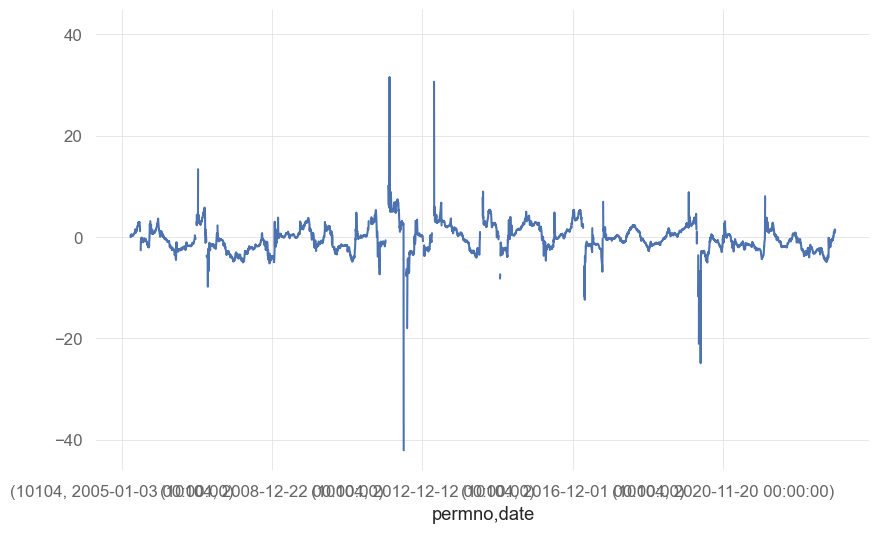

In [162]:
tsla.s_score.plot()

In [72]:
# Convert ETF Dataframe to multi-index
stock = read_stock(get_large_dir(live) / 'permno_live.csv')
sector_multi_past = create_multi_index(sector_ret_past, stock)
# Merge the necessary columns together into one dataframe
combined_past = ou_data_past[['s_score', 'kappa']].merge(beta_data_past, left_index=True, right_index=True, how='left')
combined_past = combined_past.merge(sector_multi_past, left_index=True, right_index=True, how='left')
combined_past = combined_past.merge(past_data[['RET_01']], left_index=True, right_index=True, how='left')
combined_past = combined_past.fillna(0)

In [78]:
# Retrieve the needed columns
ret_columns = [col for col in combined_past.columns if "RET_01" in col]
combined_past = combined_past[['s_score'] + ['kappa'] + ret_columns]

In [79]:
def create_signal_past(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        # Initialize signals and positions
        signals = [None] * len(group)
        positions = [None] * len(group)
        # Create masks for conditions
        open_long_condition = (group['s_score'] < -sbo) & (group['market_cap'] > threshold)
        open_short_condition = (group['s_score'] > sso) & (group['market_cap'] > threshold)
        close_long_condition = group['s_score'] > -ssc
        close_short_condition = group['s_score'] < sbc
        # Flag to check if any position is open
        position_open = False
        current_position = None
        
        for i in range(len(group)):
            if position_open:
                if positions[i-1] == 'long' and close_long_condition.iloc[i]:
                    signals[i] = 'close long'
                    positions[i] = None
                    position_open = False
                    current_position = None
                elif positions[i-1] == 'short' and close_short_condition.iloc[i]:
                    signals[i] = 'close short'
                    positions[i] = None
                    position_open = False
                    current_position = None
                else:
                    signals[i] = 'hold'
                    positions[i] = current_position
            else:
                if open_long_condition.iloc[i]:
                    positions[i] = 'long'
                    signals[i] = 'buy to open'
                    current_position = 'long'
                    position_open = True
                elif open_short_condition.iloc[i]:
                    positions[i] = 'short'
                    signals[i] = 'sell to open'
                    position_open = True
                    current_position = 'short'

        return pd.DataFrame({'signal': signals, 'position': positions}, index=group.index)

    # Sort data
    data = data.sort_index(level=['permno', 'date'])
    # Group by permno and apply the rules for each group
    results = data.groupby('permno').apply(apply_rules).reset_index(level=0, drop=True)
    # Flatten the results and assign back to the data
    data = data.join(results)
    return data

In [131]:
sbo = 0.15
sso = 0.15
sbc = 0.02
ssc = 0.02

# sbo = -0.05
# sso = -0.25
# sbc = 0.25
# ssc = 0.10

# Create signals
copy = combined_past.copy(deep=True)
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
copy = copy.merge(misc, left_index=True, right_index=True, how='left')
result_past = create_signal_past(copy, sbo, sso, sbc, ssc, threshold)

In [132]:
def dis_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display(HTML(html_str.replace('table','table style="display:inline"')))

In [133]:
result_past.loc[~result_past.signal.isnull()][['signal', 'position']]

signal position
permno date                             
10078  2005-06-23  sell to open    short
       2005-06-24          hold    short
       2005-06-27          hold    short
       2005-06-28          hold    short
       2005-06-29          hold    short
...                         ...      ...
93436  2023-09-15          hold    short
       2023-09-18          hold    short
       2023-09-19          hold    short
       2023-09-20          hold    short
       2023-09-21   close short     None

[1849452 rows x 2 columns]

In [134]:
tsla = get_stock_data(ou_data_past, 93436)

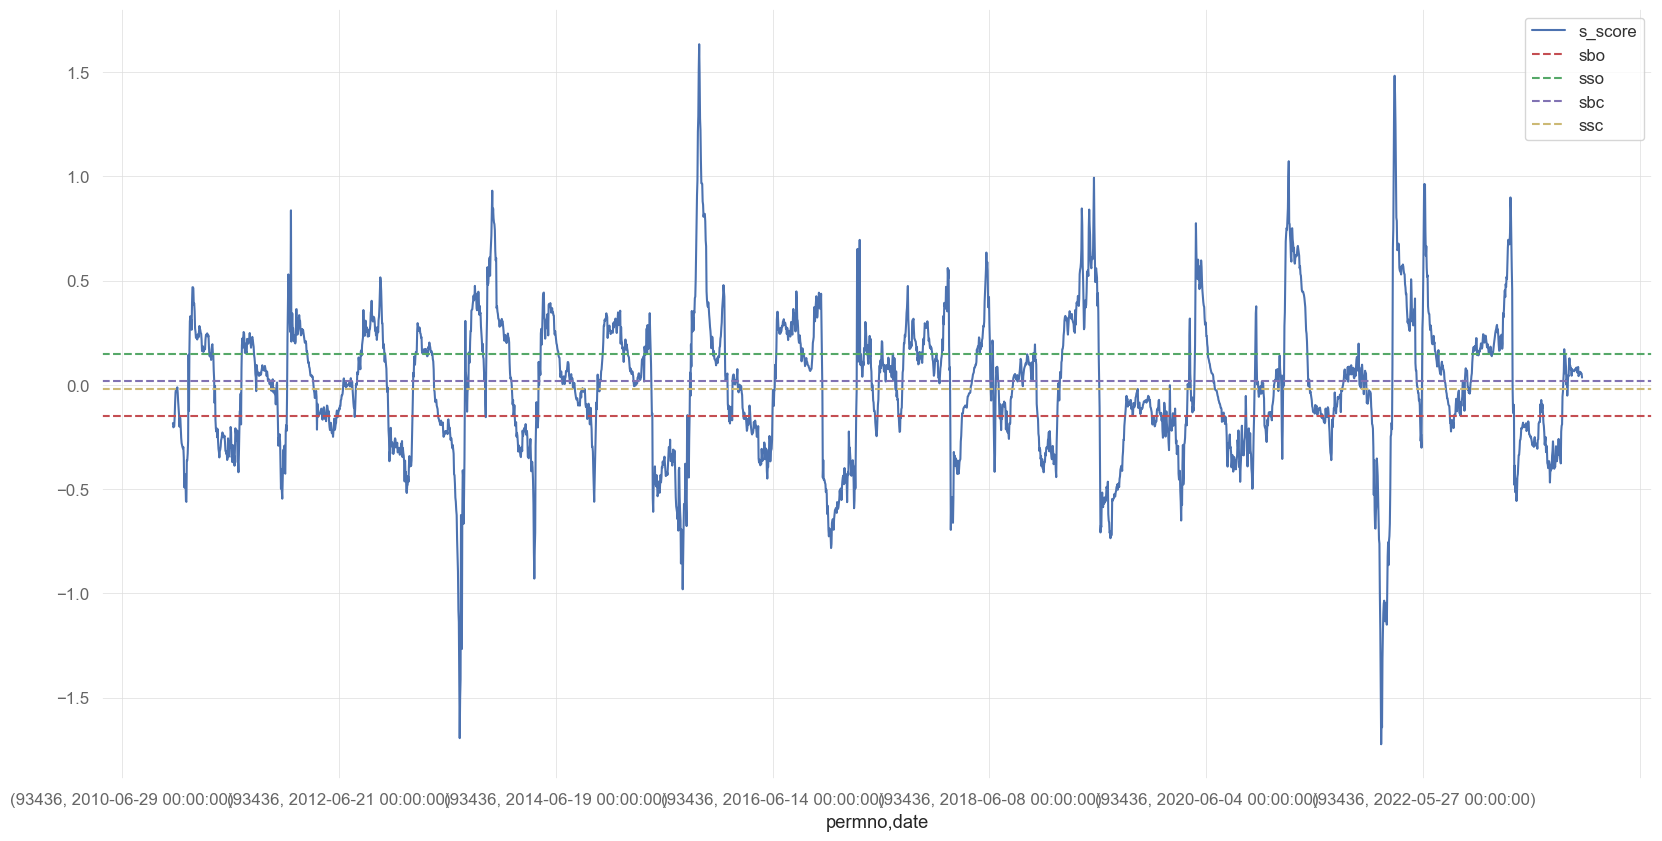

In [135]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the s_score
tsla.s_score.plot(ax=ax)
# Plot the threshold lines
ax.axhline(y=-sbo, color='r', linestyle='--', label='sbo')
ax.axhline(y=sso, color='g', linestyle='--', label='sso')
ax.axhline(y=sbc, color='m', linestyle='--', label='sbc')
ax.axhline(y=-ssc, color='y', linestyle='--', label='ssc')
# Add legend
ax.legend()
# Display the plot
plt.show()

In [136]:
def calc_total_ret(df, beta_columns, etf_returns):
    print("Get hedge weights...")
    mask_long = df['position'] == 'long'
    mask_short = df['position'] == 'short'
    df['hedge_weight'] = np.where(mask_long, -1, np.where(mask_short, 1, 0))
    
    # Get net hedge betas
    print("Get net hedge betas...")
    beta_columns = [col for col in df.columns if '_sector_' in col]
    weighted_betas = df[beta_columns].multiply(df['hedge_weight'], axis=0)
    net_hedge_betas = weighted_betas.groupby('date').sum()
    
    # Combine and normalize weights
    print("Normalize weights...")
    df['stock_weight'] = np.where(mask_long, 1, np.where(mask_short, -1, 0))
    
    # Normalize net hedge betas and stock weights combined
    df['abs_stock_weight'] = df['stock_weight'].abs()
    combined_weights = df.groupby('date')['abs_stock_weight'].sum() + net_hedge_betas.abs().sum(axis=1)
    df['normalized_weight'] = df['stock_weight'].div(combined_weights, axis=0)
    normalized_net_hedge_betas = net_hedge_betas.div(combined_weights, axis=0)
    
    # Get net hedge return
    print("Get net hedge returns...")
    net_hedge_returns = pd.DataFrame(index=normalized_net_hedge_betas.index)
    for beta in beta_columns:
        etf_return_column = beta.split('_sector_')[0]
        if etf_return_column in etf_returns.columns:
            net_hedge_returns[beta] = normalized_net_hedge_betas[beta] * etf_returns[etf_return_column]
    
    # Get total hedge return
    print("Get total hedge return...")
    net_hedge_return_total = net_hedge_returns.sum(axis=1)
    
    print("Get daily returns...")
    daily_returns = (df['RET_01'] * df['normalized_weight']).groupby('date').sum()
    
    print("Get total returns...")
    total_returns = daily_returns + net_hedge_return_total
    
    return total_returns, daily_returns, net_hedge_return_total, normalized_net_hedge_betas, df[['normalized_weight']]

In [137]:
result_past_copy = result_past.copy(deep=True)

In [141]:
result_past_copy['RET_01'] = result_past_copy.groupby('permno')['RET_01'].shift(-1)

In [142]:
# Calculate strategy's return
ewp_ret, daily, hedge, betas, stock_weight = calc_total_ret(result_past_copy, threshold, sector_ret_past.shift(-1))

Get hedge weights...
Get net hedge betas...
Normalize weights...
Get net hedge returns...
Get total hedge return...
Get daily returns...
Get total returns...


In [143]:
dis_side(stock_weight.abs().groupby('date').sum().rename(columns={'normalized_weight':'stock'}).tail(5), betas.groupby('date').sum().abs().sum(axis=1).to_frame().rename(columns={0:'beta'}).tail(5))

,stock
date,
2023-11-06,0.735595
2023-11-07,0.734204
2023-11-08,0.761317
2023-11-09,0.770497
2023-11-10,0.744730
,beta
date,
2023-11-06,0.264405
2023-11-07,0.265796


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-06-22   2005-06-22
End Period                 2023-11-10   2023-11-10
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          262.73%      -7.14%
CAGR﹪                     4.95%        -0.28%

Sharpe                     0.46         -0.19
Prob. Sharpe Ratio         97.45%       20.35%
Smart Sharpe               0.46         -0.19
Sortino                    0.64         -0.27
Smart Sortino              0.64         -0.27
Sortino/√2                 0.45         -0.19
Smart Sortino/√2           0.45         -0.19
Omega                      0.97         0.97

Max Drawdown               -56.47%      -13.27%
Longest DD Days            1982         5861
Volatility (ann.)          19.58%       1.98%
R^2                        0.0          0.0
Information Ratio          -0.03        -0.03
Calmar       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-10-25,2022-08-18,2023-11-10,5861,-13.266630,-12.603704
2,2007-05-30,2007-08-22,2007-10-22,146,-1.474493,-1.406197
3,2005-11-22,2006-03-07,2006-04-19,149,-1.262746,-1.240579
4,2005-07-29,2005-08-17,2005-08-29,32,-0.621726,-0.566100
5,2007-02-27,2007-03-28,2007-05-14,77,-0.567162,-0.562802


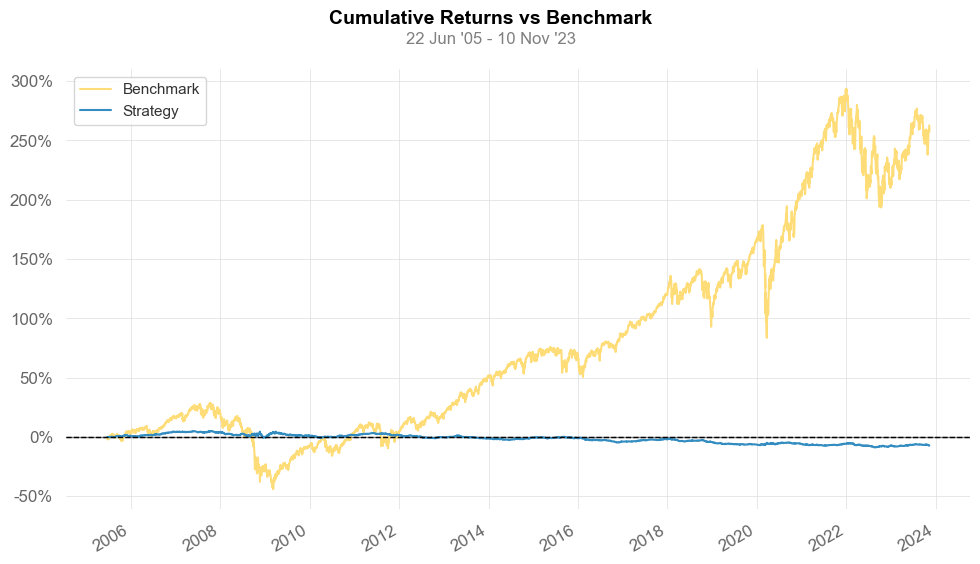

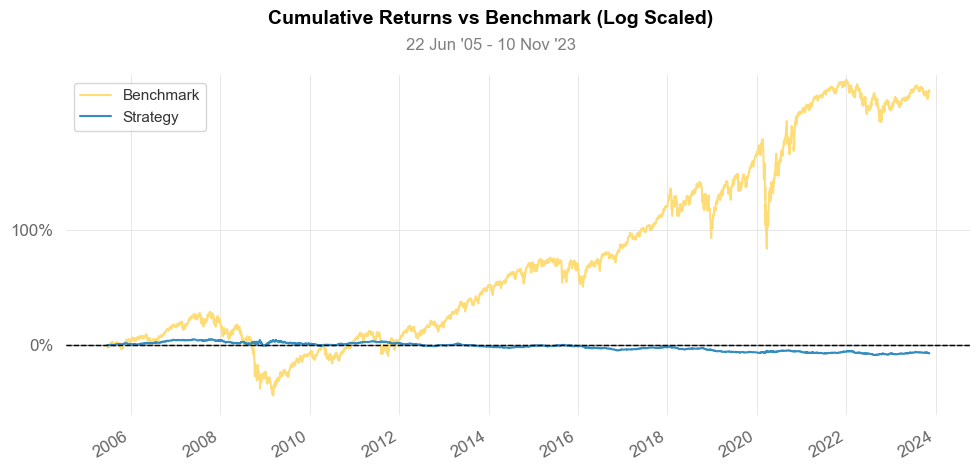

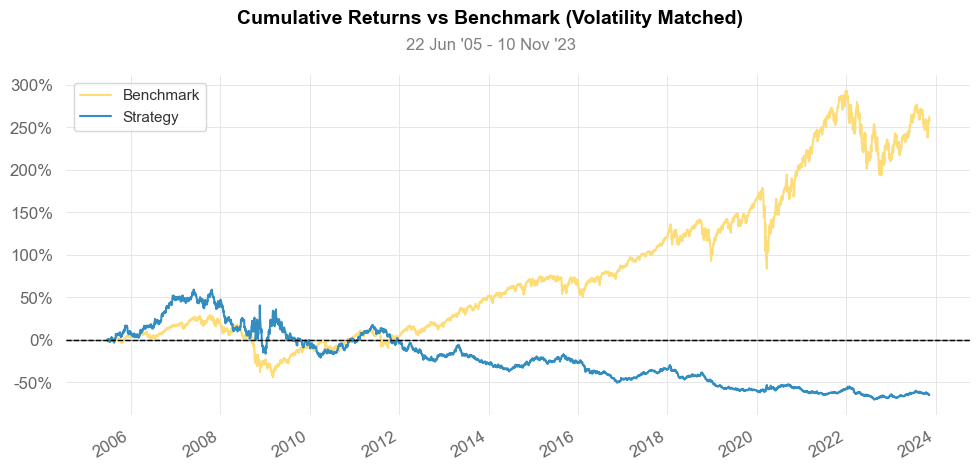

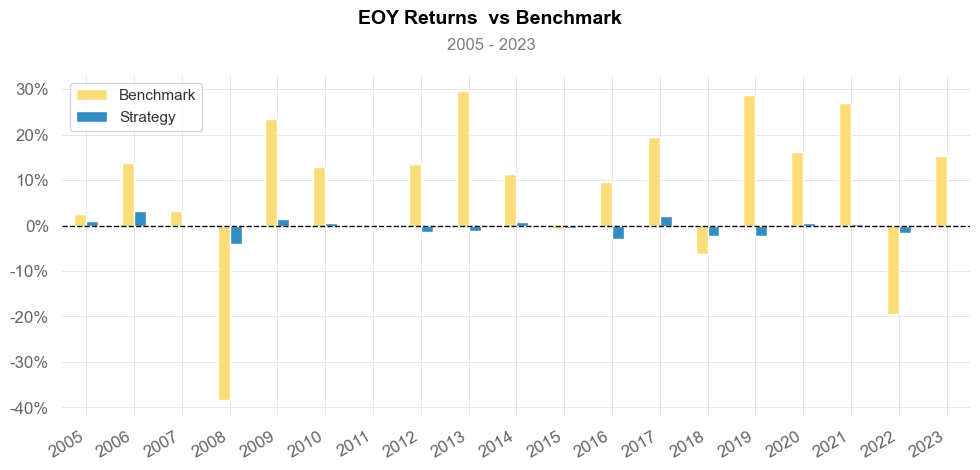

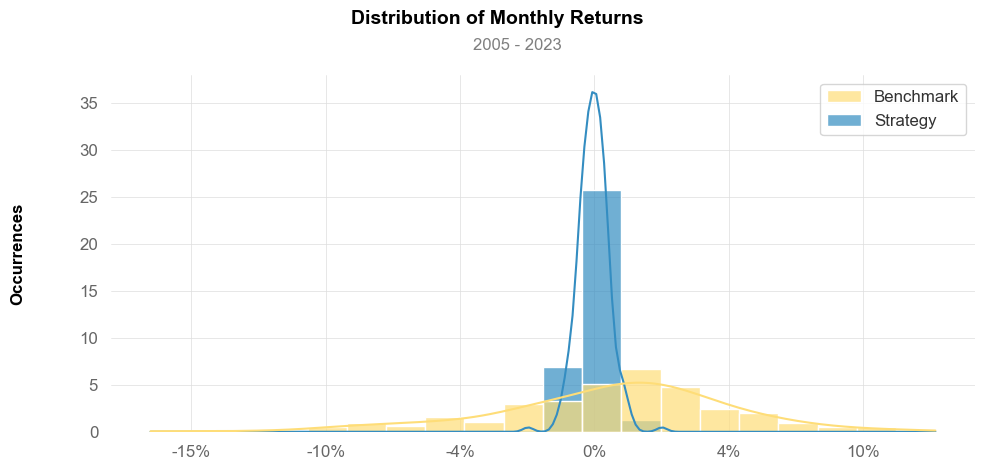

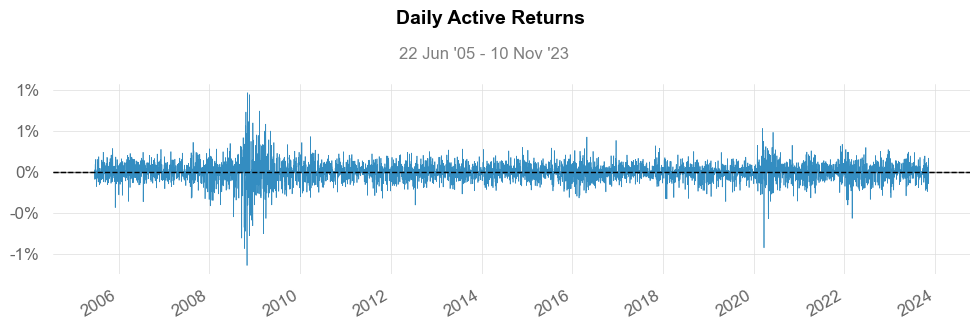

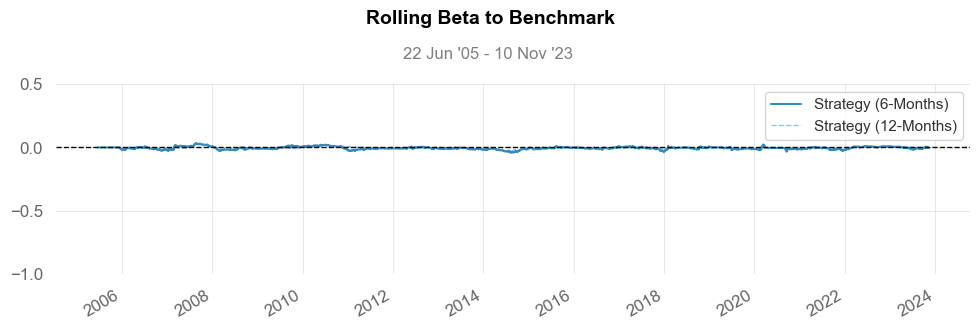

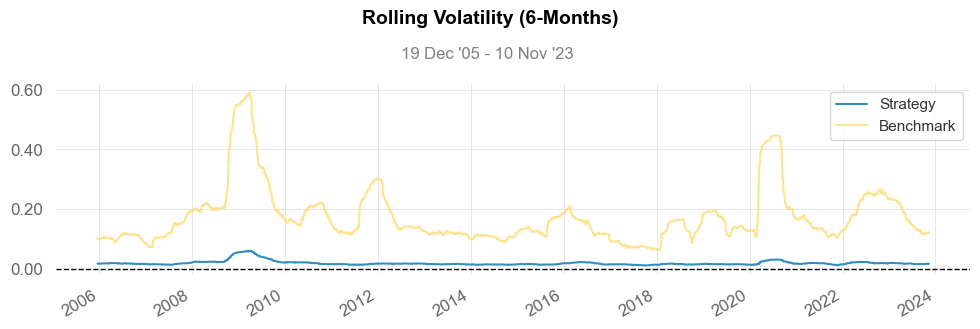

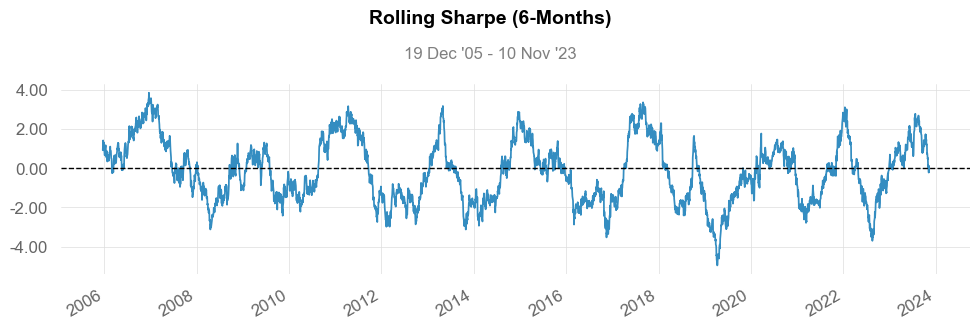

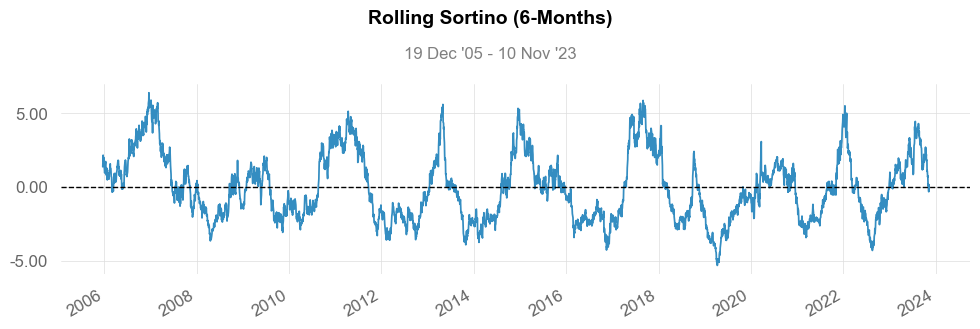

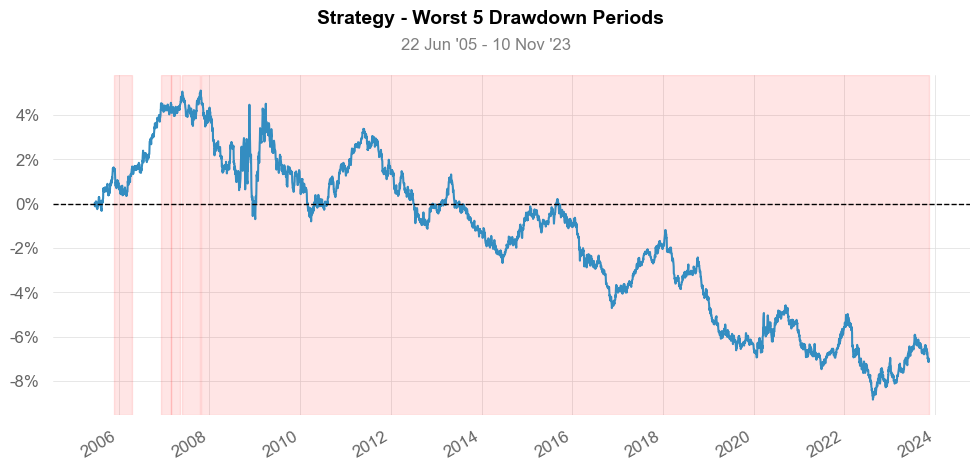

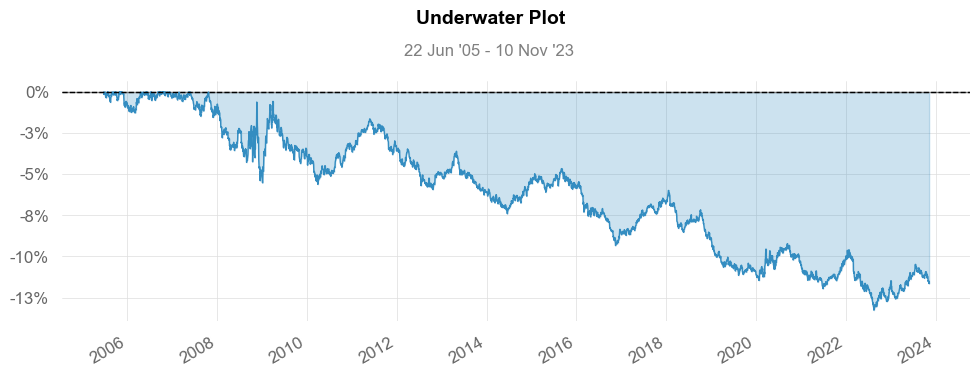

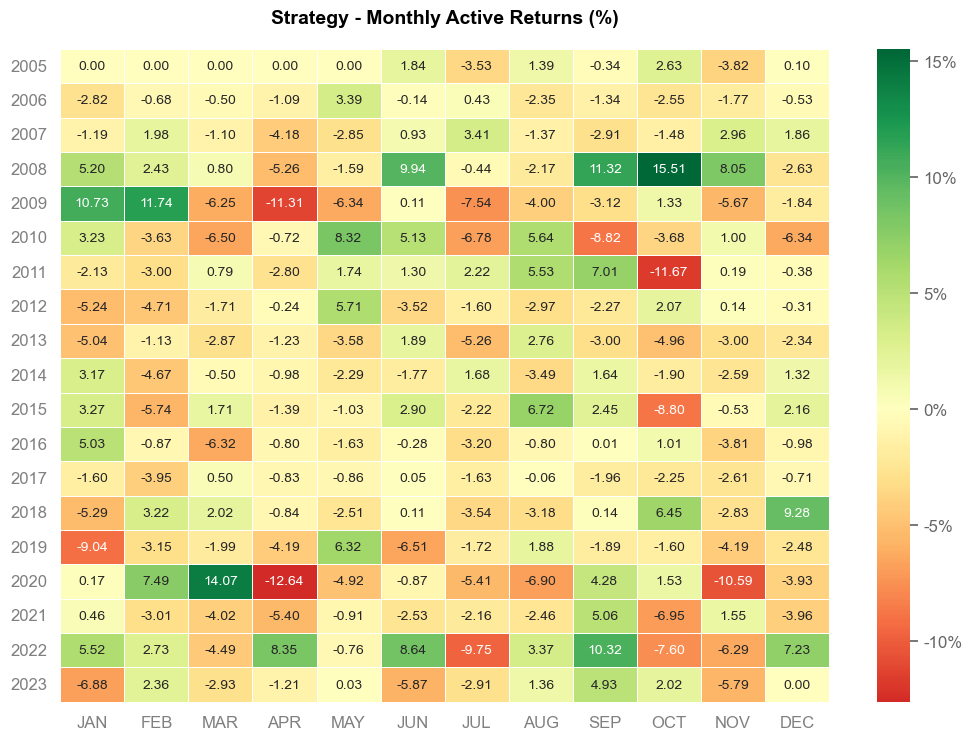

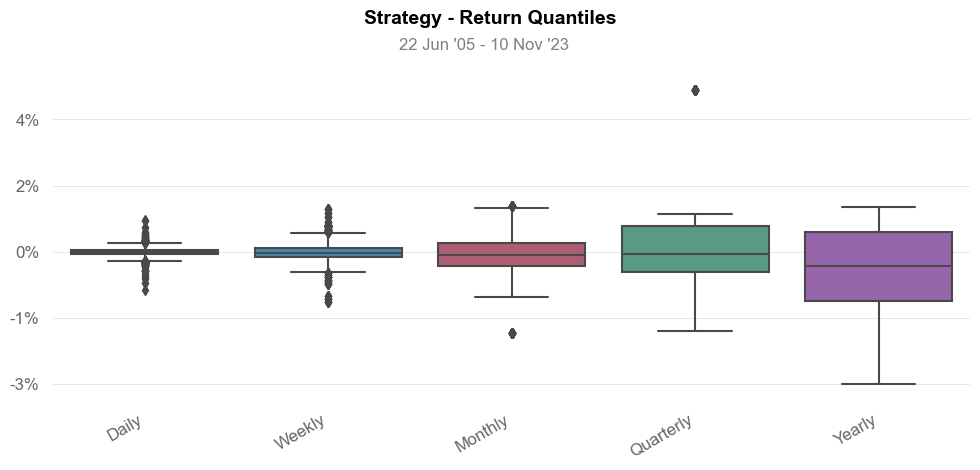

In [144]:
# Plot Results
spy = get_spy(start_date='2005-01-01', end_date=current_date)
qs.reports.full(ewp_ret, spy, figsize=(10, 5))

In [ ]:
# Export data
result_past[['signal', 'position', 'market_cap', 'num_assets', 'weight', 'hedge_weight']].to_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')

# Live

In [442]:
# Read in ETF data from FMP
T = [1]
sector_ret_live = get_data_fmp(ticker_list=['XLY', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU'], start=start, current_date=current_date)
sector_ret_live = sector_ret_live[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_live = sector_ret_live.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_live = create_return(sector_ret_live, T)
sector_ret_live = sector_ret_live.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_live = sector_ret_live.unstack('ticker').swaplevel(axis=1)
sector_ret_live.columns = ['_'.join(col).strip() for col in sector_ret_live.columns.values]
sector_ret_live = sector_ret_live.fillna(0)

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03ticker/s]


In [443]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
live_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_live = sector_ret_live.columns
live_data = create_return(live_data, T)
live_data = live_data.fillna(0)

In [446]:
# Function that executes the RollingOLS for the last window of data (this function will be parallelized)
def per_stock_ols_last(stock_data, ret, factor_data, factor_cols, window, stock_name, index_name):
    # Set up data
    model_data = stock_data[[ret]].merge(factor_data, on='date').dropna()
    model_data = model_data[[ret] + factor_cols]
    model_data = model_data.iloc[-window:]
    # Train model
    exog = sm.add_constant(model_data[factor_cols])
    model = OLS(model_data[ret], exog)
    results = model.fit()
    # Get betas
    factor_model_params = results.params.to_frame().T
    factor_model_params.rename(columns={'const': 'ALPHA'}, inplace=True)
    # Get predictions
    predicted_last = (exog.iloc[-1] * factor_model_params.iloc[-1]).sum()
    predicted_series = pd.Series(predicted_last, name='pred')
    # Compute residuals (epsilon) for the last observation
    epsilon_last = model_data[ret].iloc[-1] - predicted_last
    epsilon_series = pd.Series(epsilon_last, name='epsil')
    # Format data
    result = factor_model_params.assign(epsil=epsilon_series, pred=predicted_series)
    result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    permnos = result.index.get_level_values(0)
    new_index = pd.MultiIndex.from_product([permnos, [pd.to_datetime(current_date)]], names=['permno', 'date'])
    result.index = new_index
    return result

# Function to execute the parallelization for last window of data
def rolling_ols_last(data, ret, factor_data, factor_cols, window, name):
    valid_groups = [(name, group) for name, group in data.groupby(level='permno') if current_data(group, current_date, window)]
    tasks = [(group, ret, factor_data, factor_cols, window, permno, data.index.names[0]) for permno, group in valid_groups]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ols_last)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [447]:
# Execute Rolling LR
beta_data_live = rolling_ols_last(data=live_data, ret=ret, factor_data=sector_ret_live, factor_cols=factor_col_live.tolist(), window=window, name=f'sector_01')
beta_data_live = beta_data_live[beta_data_live.columns[1:11]]
# Combine live beta with historical beta
beta_data_past = pd.read_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')
beta_data_live = pd.concat([beta_data_past, beta_data_live], axis=0).sort_index(level=['permno', 'date'])
# Get Xk, Xk Lag, and Xk Diff for OU Process (only for the last window of data)
current_permnos = beta_data_live[beta_data_live.index.get_level_values('date') == pd.to_datetime(current_date)].index.get_level_values('permno').unique()
window_sums = beta_data_live[beta_data_live.index.get_level_values('permno').isin(current_permnos)].groupby('permno')[f'epsil_sector_01_{window:02}'].transform(lambda x: x.tail(window).sum())
last_indices = beta_data_live.loc[(slice(None), current_date), :].index
beta_data_live.loc[last_indices, 'Xk'] = window_sums.loc[last_indices]
beta_data_live['Xk_lag'] = beta_data_live['Xk'].groupby('permno').shift(-1)
beta_data_live['Xk_diff'] = beta_data_live['Xk'].groupby('permno').diff()
beta_data_live = beta_data_live.fillna(0)
# Update Data
# beta_data_live.to_parquet(get_strategy_mrev_data() / 'data_beta_etf.parquet.brotli')

In [450]:
# Function that executes the OU Regression for last window of data (this function will be parallelized)
def per_stock_ou_last(stock_data, ret, factor_col, window, stock_name, index_name):
    # Get Data
    model_data = stock_data.iloc[-window:].fillna(0)
    exog = sm.add_constant(model_data[factor_col])
    # Train model
    model = OLS(model_data[ret], exog)
    results = model.fit()
    # Get betas
    factor_model_params = results.params.to_frame().T
    factor_model_params.rename(columns={'const': 'ALPHA'}, inplace=True)
    # Format data
    result = factor_model_params
    result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    permnos = result.index.get_level_values(0)
    new_index = pd.MultiIndex.from_product([permnos, [pd.to_datetime(current_date)]], names=['permno', 'date'])
    result.index = new_index
    return result

# Function to execute the parallelization for last window of data
def exec_ou_last(data, ret='Xk_diff', factor_col='Xk_lag', window=window, name='ss'):
    valid_groups = [(name, group) for name, group in data.groupby(level='permno') if current_data(group, current_date, window)]
    tasks = [(group, ret, factor_col, window, permno, data.index.names[0]) for permno, group in valid_groups]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ou_last)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [451]:
# Read in historical OU Process Data
ou_data_past = pd.read_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')
# Execute OU Process
ou_data_live = exec_ou_last(beta_data_live)
ou_data_live.columns = ['a', 'b']
ou_data_live = ou_data_live.merge(beta_data_live[['Xk_diff', 'Xk_lag']], left_index=True, right_index=True, how='right')
ou_data_live = ou_data_live.sort_index(level=['permno', 'date'])
# Round the entire DataFrame (this is for inconsistencies in float calculations)
decimal_places = 5
ou_data_live = ou_data_live.round(decimal_places)
# Execute calculations for s-score
ou_data_live['kappa'] = -np.log(ou_data_live['b']) * 252
ou_data_live['m'] = ou_data_live['a'] / (1 - ou_data_live['b'])
# Create a new dataframe to calculate variance across historical data up to current date
variance_concat = pd.concat([ou_data_past, ou_data_live], axis=0).sort_index(level=['permno', 'date'])
# Make sure to groupby 'permno' when calculating variance
variance_concat['var_Xk_diff'] = variance_concat.groupby('permno')['Xk_diff'].transform('var')
ou_data_live = ou_data_live.merge(variance_concat[['var_Xk_diff']], left_index=True, right_index=True, how='left')
ou_data_live['sigma'] = np.sqrt(ou_data_live['var_Xk_diff'] * 2 * ou_data_live['kappa'] / (1 - ou_data_live['b']**2))
ou_data_live['sigma_eq'] = np.sqrt(ou_data_live['var_Xk_diff'] / (1 - ou_data_live['b']**2))
ou_data_live['s_score'] = -ou_data_live['m'] / ou_data_live['sigma_eq']
ou_data_live = ou_data_live.loc[ou_data_live.index.get_level_values('date')==current_date]
# Add the end of past OU dataset
ou_data_live = pd.concat([ou_data_past, ou_data_live], axis=0).sort_index(level=['permno', 'date'])
# Update Data
# ou_data_live.to_parquet(get_strategy_mrev_data() / 'data_ou_etf.parquet.brotli')

In [453]:
# Convert ETF Dataframe to multi-index
sector_multi_live = create_multi_index(sector_ret_live, stock)
# Merge the necessary columns together into one dataframe
combined_live = ou_data_live[['s_score']].merge(beta_data_live, left_index=True, right_index=True, how='left')
combined_live = combined_live.merge(sector_multi_live, left_index=True, right_index=True, how='left')
combined_live = combined_live.merge(live_data[['RET_01']], left_index=True, right_index=True, how='left')
signal_past = pd.read_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')
combined_live = combined_live.merge(signal_past[['signal', 'position']], left_index=True, right_index=True, how='left')
combined_live = combined_live.fillna(0)

In [454]:
# Retrieve necessary columns
combined_live = combined_live[['s_score', 'signal', 'position', 'RET_01',
                     f'XLB_RET_01_sector_01_{window:02}',
                     f'XLE_RET_01_sector_01_{window:02}',
                     f'XLF_RET_01_sector_01_{window:02}',
                     f'XLI_RET_01_sector_01_{window:02}',
                     f'XLK_RET_01_sector_01_{window:02}',
                     f'XLP_RET_01_sector_01_{window:02}',
                     f'XLU_RET_01_sector_01_{window:02}',
                     f'XLV_RET_01_sector_01_{window:02}',
                     f'XLY_RET_01_sector_01_{window:02}',
                     'XLB_RET_01','XLE_RET_01', 'XLF_RET_01', 'XLI_RET_01', 
                     'XLK_RET_01', 'XLP_RET_01', 'XLU_RET_01', 'XLV_RET_01', 'XLY_RET_01']]

In [460]:
# Create signals for current date data
def create_signal_live(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        if current_date in group.index.get_level_values('date'):
            # Retrieve the current date's s_score and market_cap
            current_s_score = group.iloc[-1]['s_score']
            market_cap = group.iloc[-1]['market_cap']
            # Retrieve the previous date's position
            prev_date_position = group.iloc[-2]['position']
            # Set conditions for signals and positions
            if prev_date_position == 'long':
                if current_s_score > -ssc:
                    signal = 'close long'
                    position = None
                else:
                    signal = 'hold'
                    position = 'long'
            elif prev_date_position == 'short':
                if current_s_score < sbc:
                    signal = 'close short'
                    position = None
                else:
                    signal = 'hold'
                    position = 'short'
            elif prev_date_position == None:
                if current_s_score < -sbo and market_cap > threshold:
                    signal = 'buy to open'
                    position = 'long'
                elif current_s_score > sso and market_cap > threshold:
                    signal = 'sell to open'
                    position = 'short'
            else:
                signal = None
                position = None
            return pd.Series({'signal': signal, 'position': position})
        
    # Apply the rules to each permno group and get signals and positions for the current date
    signal_positions = data.groupby(level='permno').apply(apply_rules)

    # Assign the new signals and positions to the data for the current date
    for permno in signal_positions.index:
        if pd.notna(signal_positions.loc[permno, 'signal']):
            data.loc[(permno, current_date), 'signal'] = signal_positions.loc[permno, 'signal']
            data.loc[(permno, current_date), 'position'] = signal_positions.loc[permno, 'position']
    return data

In [461]:
# Create signals
copy = combined_live.copy(deep=True)
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
copy = copy.merge(misc, left_index=True, right_index=True, how='left')
result_live = create_signal_live(copy, sbo, sso, sbc, ssc, threshold)
result_live['RET_01'] = result_live.groupby('permno')['RET_01'].shift(-1)

In [467]:
# Update weights for current date
def update_weight(df):
    # Get stock weights for the current date
    print("Update stock weights for the current date...")
    beta_columns = [col for col in df.columns if '_sector_' in col]
    num_etfs = len(beta_columns)
    stock_idx = get_stock_idx(set_timeframe(df, str(pd.to_datetime(current_date).year), str(pd.to_datetime(current_date).year + 1)))
    num_assets = len(stock_idx) + num_etfs

    # Update num_assets and weight for the current date only
    print("Update num_assets and weight for the current date only...")
    df.loc[(slice(None), current_date), 'num_assets'] = num_assets
    df.loc[(slice(None), current_date), 'weight'] = 1 / num_assets

    # Update hedge_weight for the current date only
    print("Update hedge weights for the current date...")
    mask_long = (df.loc[(slice(None), current_date), 'position'] == 'long')
    mask_short = (df.loc[(slice(None), current_date), 'position'] == 'short')
    df.loc[(slice(None), current_date), 'hedge_weight'] = np.where(
        mask_long, -df.loc[(slice(None), current_date), 'weight'],
        np.where(mask_short, df.loc[(slice(None), current_date), 'weight'], 0)
    )
    return df

In [468]:
# Read in historical signal dataframe
signal_past = pd.read_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli', columns=['num_assets', 'weight', 'hedge_weight'])
result_live = result_live.merge(signal_past, left_index=True, right_index=True, how='left')
# Update weight for dataframe
result_live = update_weight(result_live)

Update stock weights for the current date...
Update hedge weights for the current date...


In [149]:
result_live[['signal', 'position', 'market_cap', 'num_assets', 'weight', 'hedge_weight']].to_parquet(get_strategy_mrev_data() / 'data_signal_etf.parquet.brotli')

In [150]:
# Calculate strategy's return
ewp_ret = calc_total_ret(result_live, threshold, sector_ret_live.shift(-1))

In [152]:
# Export QS report
spy = get_spy(start_date='2005-01-01', end_date=current_date)
qs.reports.html(ewp_ret, spy, output=dir_path / f'{trial}.html')

[*********************100%%**********************]  1 of 1 completed


# Get Positions

In [482]:
# Get current date dataframe
trade = result_live.loc[result_live.index.get_level_values('date') == current_date]
trade = trade.fillna(0)

In [492]:
# Get weight to invest into each ETF for current date
beta_columns = [col for col in trade.columns if '_sector_' in col]
weighted_betas = trade[beta_columns].multiply(trade['hedge_weight'], axis=0)
net_hedge_betas = weighted_betas.groupby('date').sum()
net_hedge_betas.columns = [(col.split('_')[0]) for col in beta_columns]

In [256]:
# Read in ticker dataframe
ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')

In [494]:
# Get long positions
long = trade.loc[trade['signal'].str.contains('buy', na=False)]
long = long.merge(ticker, left_index=True, right_index=True, how='left')
long_ticker = list(zip(long['ticker'], long['weight']))

In [495]:
# Get short positions
short = trade.loc[trade['signal'].str.contains('short', na=False)]
short = short.merge(ticker, left_index=True, right_index=True, how='left')
short_ticker = list(zip(short['ticker'], short['weight']))

In [497]:
def display_stock(stocks, title):
    n = len(stocks)
    cols = int(math.sqrt(2 * n))
    max_length = max([len(item[0]) for item in stocks])

    text_content = f"{title}\n"
    border_line = '+' + '-' * (max_length + 3) * cols + '+\n'

    text_content += border_line
    for i in range(n):
        text_content += f"| {stocks[i][0].center(max_length)} "
        if (i + 1) % cols == 0:
            text_content += "|\n"
            text_content += border_line
    return text_content

In [ ]:
# Display stocks to long and short tomorrow
content = display_stock(long_ticker, "Stocks to Long Today:")
content += '\n\n' + display_stock(short_ticker, "Stocks to Short Today:")
print(content)

# Append long/short stocks to dataframe and export
all_columns = ['date'] + [f'Long_{i:02}' for i in range(1, len(long) + 1)] + [f'Short_{i:02}' for i in range(1, len(short) + 1)]
stock_data = [current_date] + long_ticker + short_ticker
df_combined_stock = pd.DataFrame([stock_data], columns=all_columns)
filename_stock = Path(get_strategy_mrev() / f'trade_stock_mrev.csv')

etf_columns = ['date'] + [f'ETF_{i:02}' for i in range(1, len(etf_ticker) + 1)]
etf_data = [current_date] + etf_ticker
df_combined_etf = pd.DataFrame([etf_data], columns=etf_columns)
filename_etf = Path(get_strategy_mrev() / f'trade_etf_mrev.csv')

def update_csv_for_date(filename, df_combined, current_date):
    # Check if file exists
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        # Check if the current_date already exists in the existing_df
        if current_date in existing_df['date'].values:
            existing_df = existing_df[existing_df['date'] != current_date]
        updated_df = pd.concat([existing_df, df_combined], ignore_index=True)
        updated_df.to_csv(filename, index=False)
    else:
        df_combined.to_csv(filename, index=False)

# Assuming df_combined_stock and df_combined_etf are your dataframes for stock and ETF respectively
# and filename_stock and filename_etf are the corresponding filenames for stock and ETF data
update_csv_for_date(filename_stock, df_combined_stock, current_date)
update_csv_for_date(filename_etf, df_combined_etf, current_date)